# Распознавание образов, описываемых гауссовскими случайными векторами с одинаковыми матрицами ковариаций

## Задание исходных данных

In [73]:
import numpy as np
np.set_printoptions(precision= 5, suppress=False)
m = np.matrix([[-5,1,10],[1,-4,-2],[0,8,1]]) #матожидания
C = np.matrix([[3, 1, 1],[1, 3, 1],[ 1, 1, 3]]) #матрица ковариаций
n = 3 #размерность признакового пространства
M = 3 #число классов
pw = np.array([0.3,0.4,0.3]) #априорные вероятности

## Расчет разделяющих функций и вероятностей ошибок разпознавания

In [74]:
G = np.zeros((M,n+1))
P_err, l0 = np.zeros((M,M)), np.zeros((M,M))

In [75]:
C_ = np.linalg.inv(C)

In [76]:
from scipy.stats import norm

In [77]:
for i in range(M):
    G[i,:n] = np.transpose(C_*m[:,i])
    G[i,n] = -0.5*np.transpose(m[:,i])*C_*m[:,i]
    for j in range(i+1,M):
        l0[i,j] = np.log(pw[j]/pw[i])
        h = 0.5*np.transpose((m[:,i]-m[:,j]))*C_*(m[:,i]-m[:,j])
        sD = np.sqrt(2*np.abs(h))
        P_err[i,j] = norm.cdf(l0[i,j],h,sD)
        P_err[j,i] = 1 - norm.cdf(l0[i,j],-h,sD)
    P_err[i,i] = 1 - np.sum(P_err[i,:])

In [78]:
np.set_printoptions(suppress=True)
print('Теоретическая матрица ошибок:\n {0}'.format(P_err))

Теоретическая матрица ошибок:
 [[ 0.99987  0.00013  0.     ]
 [ 0.0001   0.99988  0.00002]
 [ 0.       0.00003  0.99997]]


## Тестирование алгоритма методом статистических испытаний

In [79]:
from numpy.linalg import cholesky
def randncor(n,N,C):
    try:
        A = cholesky(C)
    except LinAlgError:
        m=0
        print('A is not positive definite')
    m = n
    u = np.random.randn(m,N)
    x = A.conj().transpose().dot(u)
    return x     

In [103]:
def experiment_error(K):
    XK = np.zeros((n, 3 * K))
    x = np.matrix(np.ones((n+1,1)))
    P_err_experiment = np.zeros((M,M))
    for k in range(K):
        for i in range(M):
            x_ = randncor(n,1,C)
            x[:n,0] = m[:,i] + x_
            XK[:n, (i - 1) * K + k] = x[:n,0].ravel()
            u = G*x+np.log(np.matrix(pw).T) #вычисление значений разделяющих функций
            um,umi = u.max(), np.where(u == u.max())[0]
            P_err_experiment[i,umi] = P_err_experiment[i,umi]+1
    P_err_experiment /=K 
    return (XK,P_err_experiment)

In [111]:
sample_size = [10,100,1000,10000,100000,1000000]
errors = [experiment_error(K) for K in sample_size]

In [157]:
for i in range(len(sample_size)):
    print('Число образов(в одном классе): {0}\n Экспериментальная матрица ошибок:\n {1}\n\n'.format(sample_size[i],errors[i][1]))

Число образов(в одном классе): 10
 Экспериментальная матрица ошибок:
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


Число образов(в одном классе): 100
 Экспериментальная матрица ошибок:
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


Число образов(в одном классе): 1000
 Экспериментальная матрица ошибок:
 [[ 1.     0.     0.   ]
 [ 0.     1.     0.   ]
 [ 0.     0.002  0.998]]


Число образов(в одном классе): 10000
 Экспериментальная матрица ошибок:
 [[ 0.9999  0.0001  0.    ]
 [ 0.0004  0.9995  0.0001]
 [ 0.      0.      1.    ]]


Число образов(в одном классе): 100000
 Экспериментальная матрица ошибок:
 [[ 0.99988  0.00012  0.     ]
 [ 0.0001   0.99981  0.00009]
 [ 0.       0.00006  0.99994]]


Число образов(в одном классе): 1000000
 Экспериментальная матрица ошибок:
 [[ 0.99985  0.00015  0.     ]
 [ 0.0001   0.99985  0.00005]
 [ 0.       0.00007  0.99993]]




## Визуализация

In [161]:
XK = errors[2][0]
K = sample_size[2]

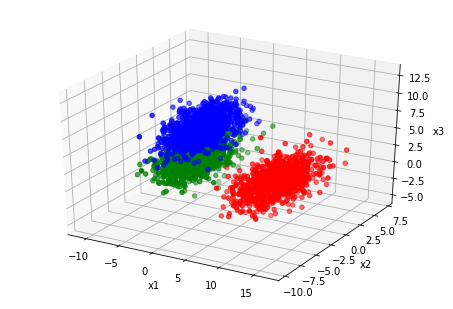

In [162]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(XK[0,:K],XK[1,:K],XK[2,:K], c = 'b')
ax.scatter(XK[0, K:2*K], XK[1, K:2*K],XK[2, K:2*K],c= 'r')
ax.scatter(XK[0, 2*K:3*K], XK[1, 2*K:3*K],XK[2, 2*K:3*K],c=  'g')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
plt.savefig('class-dist-scatter.png')
plt.show()

In [163]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Scatter3d(
    x=XK[0,:K],
    y=XK[1,:K],
    z=XK[2,:K],
    mode='markers',
    marker=dict(
        color='rgb(0,0,255)',
        size=12,
        line=dict(
            color='rgb(0,0,0)',
            width=1
        )
    ),
    name='Класс 1'
)

trace2 = go.Scatter3d(
    x=XK[0, K:2*K],
    y=XK[1, K:2*K],
    z=XK[2, K:2*K],
    mode='markers',
    marker=dict(
        color='rgb(255, 0, 0)',
        size=12,
        symbol='circle',
        line=dict(
            color='rgb(0,0,0)',
            width=1
        )
    ),
    name='Класс 2'
)

trace3 = go.Scatter3d(
    x=XK[0, 2*K:3*K], 
    y=XK[1, 2*K:3*K],
    z=XK[2, 2*K:3*K],
    mode='markers',
    marker=dict(
        size=12,
        symbol='circle',
        color='rgb(0, 255, 0)',
        line=dict(
            color='rgb(0,0,0)',
            width=1
        )
    ),
    name='Класс 3'
)
data = [trace1, trace2,trace3]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='class-dist-scatter')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mzaharchenko/0 or inside your plot.ly account where it is named 'class-dist-scatter'
